In [10]:
%load_ext autoreload

In [16]:
%autoreload
import geopandas as gpd
import matplotlib.pyplot as plt
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support

C:\Users\camilorg\AppData\Local\Continuum\anaconda3\envs\geoenv\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


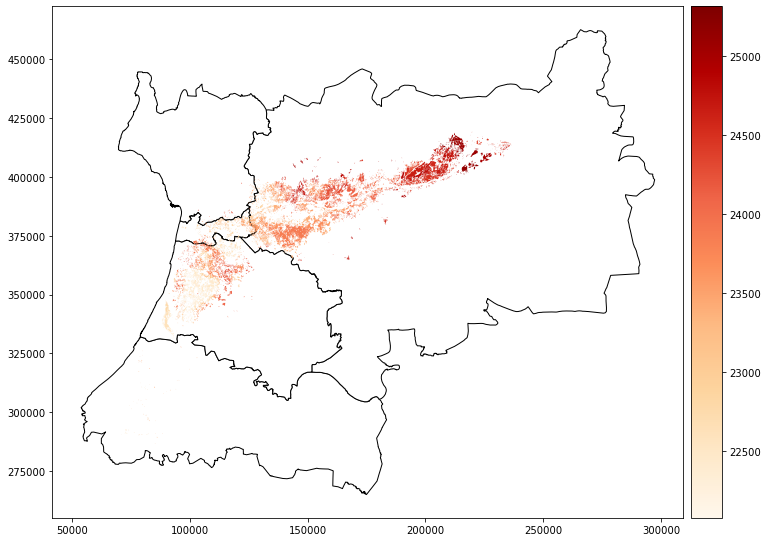

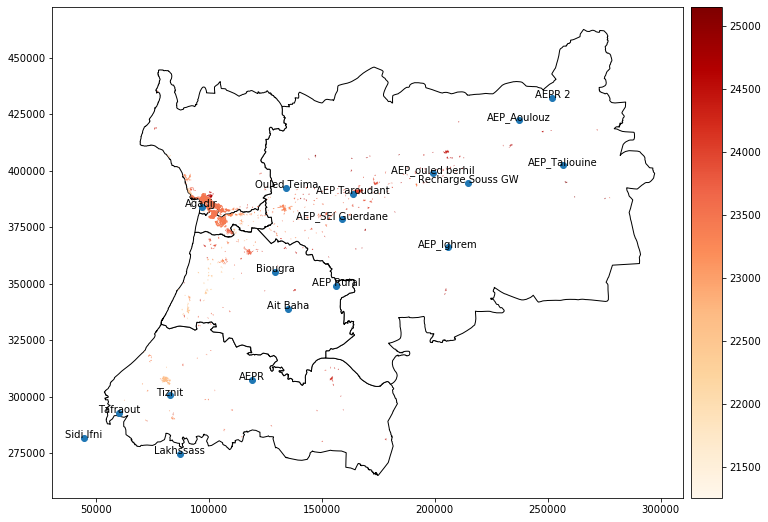

In [19]:
df = gpd.read_file(r"Data - Souss-Massa\GIS\Processed layers\cropland_2013_processed_20200218_clean.csv", encoding='utf-8')
df.drop(columns=['WKT', 'gen2013', 'area_m2'], inplace=True)
df.rename(columns={'area_ha': 'area_m2'}, inplace=True)
df.columns=df.columns.str.replace('mea','')
provinces = gpd.read_file('Data - Souss-Massa/GIS/Admin/Provinces.gpkg', encoding='utf-8')
demand_sites = gpd.read_file('Data - Souss-Massa/Schematic/Demand Sites.kml', encoding='utf-8')

for column in list(df)[0:-2]:
    df[column] = df[column].astype('float')

MerchidSudMoroc = 26192
for gdf in [provinces, demand_sites]:
    gdf.to_crs(epsg=MerchidSudMoroc, inplace=True)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

provinces.plot(color='white', edgecolor='black', ax=ax)
df.plot(column='_srad7', ax=ax, cmap='OrRd', legend=True, cax=cax)

df = gpd.read_file(r"Data - Souss-Massa\GIS\Processed layers\builtup_2013_processed_20200218_clean.csv", encoding='utf-8')
df.drop(columns=['WKT', 'fid', 'DN'], inplace=True)

for column in list(df)[0:-2]:
    df[column] = df[column].astype('float')

df.crs = f'EPSG:{MerchidSudMoroc}'

df = df.loc[df.area_m2>=100000]

df = gpd.clip(df, provinces, keep_geom_type=True)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

provinces.plot(color='white', edgecolor='black', ax=ax)
df.plot(column='_srad7', ax=ax, cmap='OrRd', legend=True, cax=cax)
demand_sites.to_crs(epsg=MerchidSudMoroc).plot(ax=ax)
for idx, row in demand_sites.to_crs(epsg=MerchidSudMoroc).iterrows():
    ax.annotate(s=row['Name'], xy=row.geometry.centroid.coords[0],
                 horizontalalignment='center')